In [1]:
%load_ext autoreload
%autoreload 2

import collections
import os
import sys

import numpy as np
import PIL
import torch
import torchvision
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../models'))
from DCGAN.model import initialize_weights, Generator, Discriminator

# Config

In [2]:
IMAGE_SIZE = 64
BASE_FEATURES_DEPTH = 64
BATCH_SIZE = 16
LATENT_DIM = 100

BETA_1 = 0.5  # hyperparameter of Adam
LEARNING_RATE = 0.0002

device = torch.device('cuda:0')

# EDA

In [3]:
image_folder = torchvision.datasets.ImageFolder(
    '../data/processed/DCGAN',
    transform=torchvision.transforms.Compose(
        (
           torchvision.transforms.Resize(IMAGE_SIZE),
           torchvision.transforms.CenterCrop(IMAGE_SIZE),
           torchvision.transforms.ToTensor(),
        )
    )
)

dataloader = torch.utils.data.DataLoader(
    image_folder, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=4
)

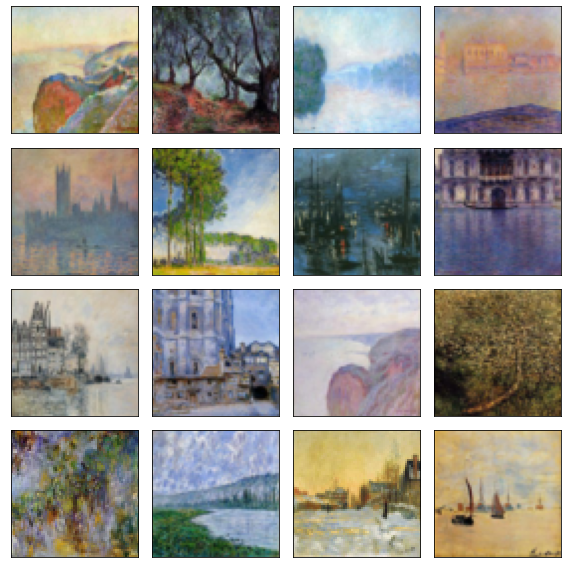

In [4]:
GRID_SIZE = 4

fig, axes = plt.subplots(
    GRID_SIZE, 
    GRID_SIZE, 
    figsize=(8, 8), 
    sharex='all', 
    sharey='all',
)

for i in range(axes.size):
    ax = axes[i // GRID_SIZE][i % GRID_SIZE]
    ax.imshow(
        (255 * image_folder[i][0].permute(1, 2, 0))
        .numpy()
        .astype(np.uint8)
    )
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

# DCGAN

## Generator

In [5]:
generator = Generator(
    latent_space_dim=LATENT_DIM, 
    base_features_depth=BASE_FEATURES_DEPTH
).to(device)
generator.apply(initialize_weights)
optimizer_generator = torch.optim.Adam(
    generator.parameters(), 
    lr=LEARNING_RATE, 
    betas=(BETA_1, 0.999)
)

## Discriminator

In [6]:
discriminator = Discriminator(
    base_features_depth=BASE_FEATURES_DEPTH
).to(device)
discriminator.apply(initialize_weights);
optimizer_discriminator = torch.optim.Adam(
    discriminator.parameters(), 
    lr=LEARNING_RATE, # needs to be increased if SpectralNorm is used
    betas=(BETA_1, 0.999)
)

## Training loop

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


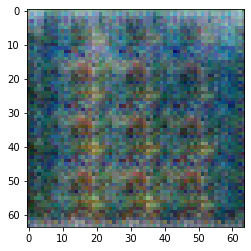

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


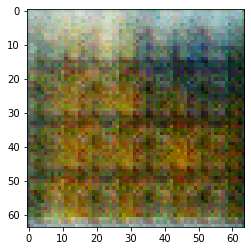

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


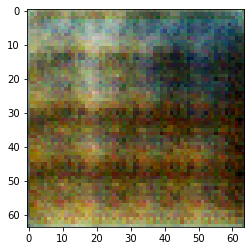

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


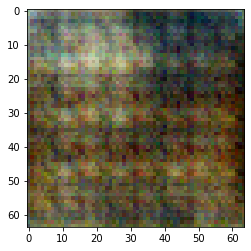

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


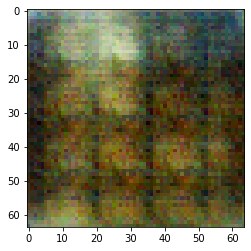

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


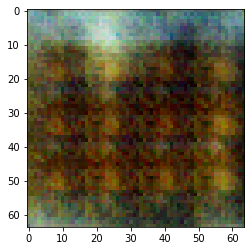

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


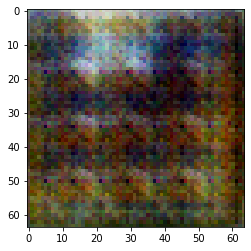

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


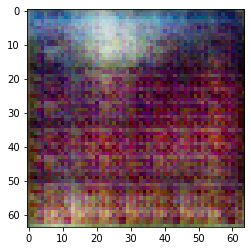

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


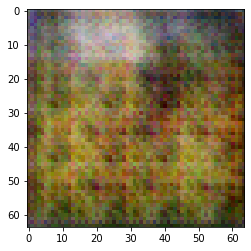

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


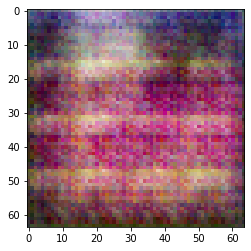

In [9]:
num_epochs = 10
loss_fn = torch.nn.BCELoss()
fixed_noize = torch.randn(
    64, LATENT_DIM, 1, 1, 
    dtype=torch.float32, device=device
)

FAKE_LABEL = 0
REAL_LABEL = 1

img_list = []
G_losses = []
D_losses = []
iter_counter = 0

for epoch in tqdm(range(num_epochs), desc='epoch'):
    for batch_id, batch in enumerate(dataloader):
        # 1. Update discriminator 
        discriminator.zero_grad()
        # 1.1. Run in on real data.
        # Batch is a tuple of form (data, label), and that label 
        # doesn't have a meaning in the scope of this application
        real_paintings_batch = batch[0].to(device) 
        batch_size = real_paintings_batch.size(0)
        real_labels_batch = torch.full(
            (batch_size, ), REAL_LABEL, 
            dtype=torch.float32, device=device
        ) 
        real_being_real_probas = discriminator(
            real_paintings_batch
        ).view(-1)
        D_loss_real = loss_fn(real_being_real_probas, real_labels_batch)
        D_loss_real.backward()
        # 1.2. Run it on fake data
        noise_batch = torch.randn(
            batch_size, LATENT_DIM, 1, 1, 
            dtype=torch.float32, device=device
        )
        fake_paintings_batch = generator(noise_batch)
        fake_labels_batch = torch.full(
            (batch_size, ), FAKE_LABEL, 
            dtype=torch.float32, device=device
        )
        fake_being_real_probas = discriminator(
            fake_paintings_batch.detach()
        ).view(-1)
        D_loss_fake = loss_fn(fake_being_real_probas, fake_labels_batch)
        D_loss_fake.backward()
        D_loss = D_loss_real + D_loss_fake
        optimizer_discriminator.step()
        
        # 2. Update generator
        generator.zero_grad()
        # As BCELoss only works with 0-1 labels,
        # it's necessary to swap the meaning of REAL_LABEL
        # and FAKE_LABEL for backpropagation to run correctly
        fake_being_real_probas = discriminator(
            fake_paintings_batch
        ).view(-1)
        flipped_fake_labels_batch = torch.full(
            (batch_size, ), REAL_LABEL, 
            dtype=torch.float32, device=device
        ) 
        # Here the gradients of discriminator are already set to 0,
        # meaning that we can do backprop through G only without worrying
        G_loss = loss_fn(fake_being_real_probas, flipped_fake_labels_batch)
        G_loss.backward()
        optimizer_generator.step()
        
    with torch.no_grad():
        plt.imshow(
            generator(fixed_noize)
            [0]
            .permute(1, 2, 0)
            .cpu()
            .numpy()
        )
        plt.show()